#CafChem tools for creating a Multi-Layer Perceptron with Pytorch and fitting to chemical data.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MauricioCafiero/CafChem/blob/main/notebooks/MLP_with_PyTorch_CafChem.ipynb)

## This notebook allows you to:
- Read in a CSV file.
- featurize data, remove NaNs, perform scaling. Split data into training and validation sets.
- Create an MLP with a user defined number of hidden layers.
- visualize predicted data.

## Requirements:
- This notebook will install deepchem and mordred
- It will pull the CafChem tools from Github.
- It will install all needed libraries.

## Set-up

### Install libraries

In [1]:
!pip install deepchem
!pip install mordred

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.4 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176718 sha256=29e02f80a81abf01f6c9772485fe3632754ab361364151e62f9ae115bc36298e
  Stored in directory: /root/.cache/pip/wheels/8b/30/0b/84e3f6775306e74cf5957ee4d16b10bf3927dcec44cc23d5f2
Successfully built mordred
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existing

### Pull CafChem from Github and import libraries

In [15]:
!git clone https://github.com/MauricioCafiero/CafChem.git

Cloning into 'CafChem'...
remote: Enumerating objects: 639, done.
remote: Counting objects: 100% (216/216), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 639 (delta 151), reused 45 (delta 45), pack-reused 423 (from 1)
Receiving objects: 100% (639/639), 41.79 MiB | 28.62 MiB/s, done.
Resolving deltas: 100% (369/369), done.


In [2]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torchsummary import summary

import CafChem.CafChemMLPPyTorch as ccmlp

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Read in data and featurize
- Can choose RDKit descriptors, Mordred descriptors, or fingerprints

In [3]:
df = pd.read_csv('/content/delaney.csv')
df.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [5]:
X, y, smiles = ccmlp.featurize(df['SMILES'], df['measured log(solubility:mol/L)'])

Old dimensions are: (1144, 217).
New dimensions are: (1144, 217)


### Use if target data should be transformed with a log function

In [44]:
trans_y = []
for i, val in enumerate(y):
  try:
    newval = np.log10(val)
    trans_y.append(newval)
  except:
    print(f"Could not transform {i}")

In [59]:
y = trans_y

## Prepare data
- scale features
- split into training and validation data
- create Torch datasets and dataloaders

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = ccmlp.train_test_split(X_scaled, y, test_size=0.2, random_state=32)

In [8]:
train_dataset, test_dataset, train_loader, test_loader = ccmlp.create_data_loader(X_train, y_train, X_test, y_test, batch_size=128)

## Create and train model
- setup loss function and optimizer
- create model with user defined numbers of neurons per layer, number of hidden layers
- train model

In [9]:
loss_function = nn.MSELoss()
model = ccmlp.MLP_Model(neurons=400, input_dims=len(X_train[0]), num_hidden_layers=6)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [10]:
epochs = 60
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  model = ccmlp.train(train_loader, model, loss_function, optimizer)
print("Done!")

Epoch 1
-------------------------------
Batch: 0, Loss: 14.2021427 [    0/  915]
Batch: 2, Loss: 13.2881546 [  256/  915]
Batch: 4, Loss: 11.9737911 [  512/  915]
Batch: 6, Loss: 10.1018705 [  768/  915]
Epoch 2
-------------------------------
Batch: 0, Loss: 3.4550323 [    0/  915]
Batch: 2, Loss: 3.9007094 [  256/  915]
Batch: 4, Loss: 4.5574532 [  512/  915]
Batch: 6, Loss: 5.4709783 [  768/  915]
Epoch 3
-------------------------------
Batch: 0, Loss: 4.6212354 [    0/  915]
Batch: 2, Loss: 4.4124150 [  256/  915]
Batch: 4, Loss: 3.4093308 [  512/  915]
Batch: 6, Loss: 3.2954695 [  768/  915]
Epoch 4
-------------------------------
Batch: 0, Loss: 1.6549163 [    0/  915]
Batch: 2, Loss: 1.4250435 [  256/  915]
Batch: 4, Loss: 1.5029166 [  512/  915]
Batch: 6, Loss: 1.3498832 [  768/  915]
Epoch 5
-------------------------------
Batch: 0, Loss: 0.9559766 [    0/  915]
Batch: 2, Loss: 1.1357055 [  256/  915]
Batch: 4, Loss: 1.1156681 [  512/  915]
Batch: 6, Loss: 1.0010825 [  768/  9

## Evaluate model
- calculate R2 for training and test data
- use the model to serve predictions

Train R2 Score: 0.9722880361269082
Test R2 Score: 0.897453689079754


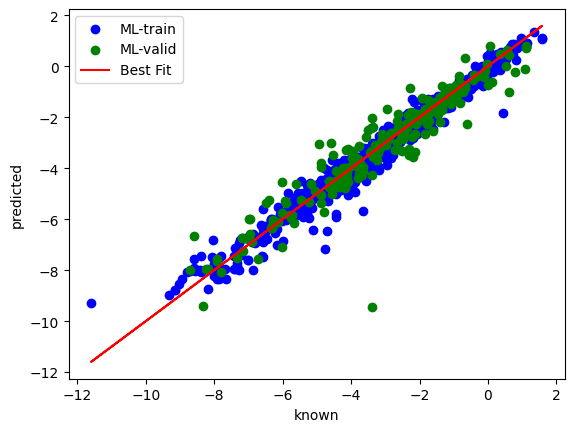

In [11]:
r2_train, r2_test = ccmlp.evaluate_training(X_train, y_train, X_test, y_test, model)

In [12]:
which = 500
prediction = ccmlp.predict_single_value(smiles[which], model, "rdkit", scaler, truth=y[which])

Predicting value for ClC(Cl)(Cl)N(=O)=O
Prediction: -2.0996994972229004, Truth: -2.0


## Save the model

In [13]:
torch.save(model.state_dict(), "saved_model.pt")

## Load a saved model
- needs two files from the previous model:
  * the MLP_model_params.txt file
  * the saved_model.pt file
- Both should be in the current folder [("/content") on Colab]

In [17]:
new_model = ccmlp.load_model()

In [18]:
prediction = ccmlp.predict_single_value(smiles[which], new_model, "rdkit", scaler, truth=y[which])

Predicting value for ClC(Cl)(Cl)N(=O)=O
Prediction: -2.0996994972229004, Truth: -2.0
